In [1]:
from train_model import *

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# mlp_1 = pd.read_csv('models/0201_MLP_env_1x1_weighted_loss_05_all_PA_species_with_pseudoabsences/last_auc.csv').rename(columns={'auc':'mlp_1'})
# mlp_4 = pd.read_csv('models/0206_MLP_env_4x4_weighted_loss_05/last_auc.csv').rename(columns={'auc':'mlp_4'})
# mlp_16 = pd.read_csv('models/0205_MLP_env_16x16_weighted_loss_05/last_auc.csv').rename(columns={'auc':'mlp_16'})
# cnn_16 = pd.read_csv('models/0205_CNN_env_16x16_weighted_loss_05/last_auc.csv').rename(columns={'auc':'cnn_16'})
# df = pd.merge(mlp_1, pd.merge(mlp_4, pd.merge(mlp_16, cnn_16)))
# df['mlp_4_mlp_1'] = df['mlp_4'] - df['mlp_1']
# df['mlp_16_mlp_1'] = df['mlp_16'] - df['mlp_1']
# df['cnn_16_mlp_1'] = df['cnn_16'] - df['mlp_1']
# df

In [28]:
sat128 = pd.read_csv('models/0214_resnet_sat_128x128_pretrained/best_val_auc_auc.csv').rename(columns={'auc':'sat128'})
sat32 = pd.read_csv('models/0216_resnet_sat_32x32_pretrained/best_val_auc_auc.csv').rename(columns={'auc':'sat32'})
df = pd.merge(sat128, sat32)
df['delta_128_32'] = df['sat128'] - df['sat32']
df

,species,n_occ,sat128,sat32,delta_128_32
0,1,1125,0.612464,0.683658,-0.071195
1,5,2243,0.410753,0.516905,-0.106152
2,10,1085,0.877869,0.755603,0.122266
3,11,2284,0.697038,0.544941,0.152096
4,24,2315,0.533725,0.522874,0.010851
...,...,...,...,...,...
2134,10028,93,0.912710,0.938758,-0.026048
2135,10031,9,0.812155,0.148447,0.663708
2136,10035,60,0.516109,0.470459,0.045650
2137,10038,6,0.541616,0.203173,0.338443


In [29]:
df['n_occ_cat'] = pd.cut(df['n_occ'], [1, 50, 500, 2000, 2500])#[1, 50, 500, 3000, 4600]) 
print(df.groupby('n_occ_cat').count().species)

n_occ_cat
(1, 50]         494
(50, 500]       617
(500, 2000]     464
(2000, 2500]    507
Name: species, dtype: int64


In [30]:
auc_melt = pd.melt(df, #.sort_values('mlp_1').reset_index(drop=True).reset_index(), 
                  id_vars=['species', 'n_occ', 'n_occ_cat'], 
                  value_vars=['sat128','sat32'],#['mlp_1', 'mlp_4', 'mlp_16', 'cnn_16'],
                  var_name='model', value_name='AUC')
auc_melt

,species,n_occ,n_occ_cat,model,AUC
0,1,1125,"(500, 2000]",sat128,0.612464
1,5,2243,"(2000, 2500]",sat128,0.410753
2,10,1085,"(500, 2000]",sat128,0.877869
3,11,2284,"(2000, 2500]",sat128,0.697038
4,24,2315,"(2000, 2500]",sat128,0.533725
...,...,...,...,...,...
4273,10028,93,"(50, 500]",sat32,0.938758
4274,10031,9,"(1, 50]",sat32,0.148447
4275,10035,60,"(50, 500]",sat32,0.470459
4276,10038,6,"(1, 50]",sat32,0.203173


In [32]:
# delta_auc_melt = pd.melt(df, #.sort_values('mlp_1').reset_index(drop=True).reset_index(), 
#                   id_vars=['species', 'n_occ', 'n_occ_cat'], 
#                   value_vars=['mlp_4_mlp_1', 'mlp_16_mlp_1', 'cnn_16_mlp_1'],
#                   var_name='models', value_name='delta_AUC')
# delta_auc_melt

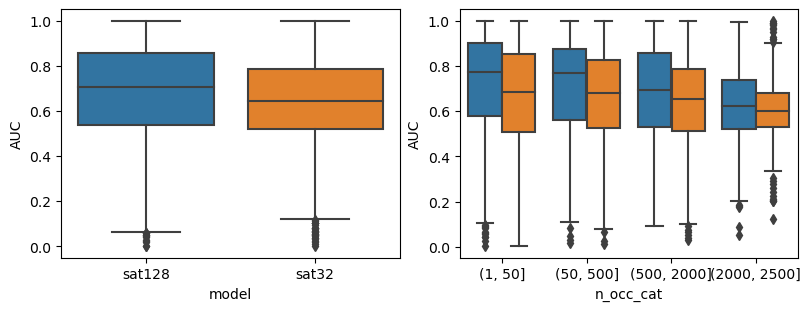

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2,layout='constrained', figsize=(8,3))
sns.boxplot(auc_melt, x='model', y='AUC', ax=ax1)
sns.boxplot(auc_melt, x='n_occ_cat', y='AUC', hue='model', ax=ax2)
ax2.legend([],[], frameon=False)
plt.show()

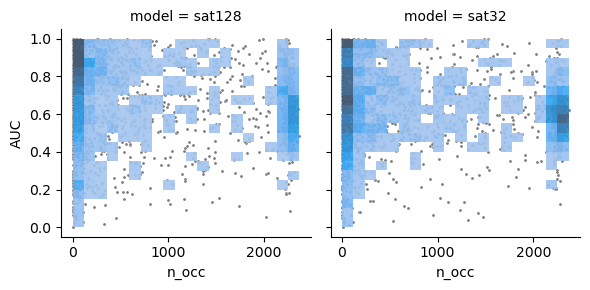

In [32]:
g = sns.FacetGrid(auc_melt, col='model')
g.map(sns.scatterplot, 'n_occ', 'AUC', s=5, color='grey')
g.map(sns.histplot, 'n_occ', 'AUC', bins=20, pthresh=0.05, pmax=0.95, alpha=0.9)

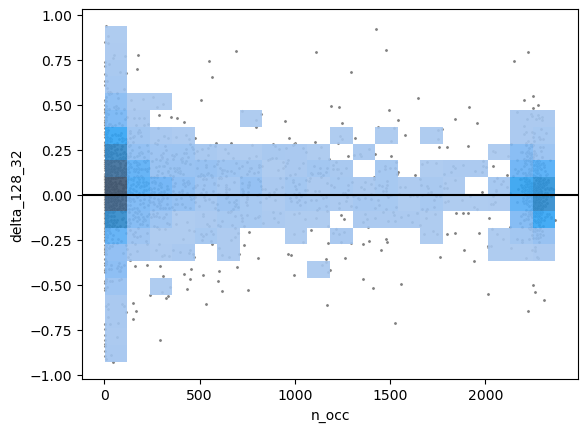

In [33]:
g = sns.scatterplot(df, x='n_occ', y='delta_128_32', s=5, color='grey')
g = sns.histplot(df, x='n_occ', y='delta_128_32', bins=20, pthresh=0.05, pmax=0.95, alpha=0.9)
g.axhline(0, color='k')

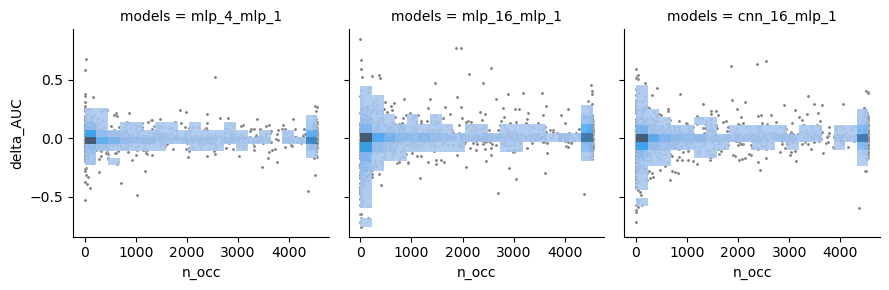

In [22]:
g = sns.FacetGrid(delta_auc_melt, col='models')
g.map(sns.scatterplot, 'n_occ', 'delta_AUC', s=5, color='grey')
g.map(sns.histplot, 'n_occ', 'delta_AUC', bins=20, pthresh=0.05, pmax=0.95, alpha=0.9)

In [3]:
run_name = '0219_MultiScale_env_1_sat_128x128'
model_setup={'env': {
    'model_name':'MLP', 'covariates':[bioclim_dir, soil_dir, landcover_path],
    'patch_size': 1, 'n_layers': 5, 'width': 1280, 'dropout': 0.5
}, 'sat': {
    'model_name':'ResNet', 'covariates':[sat_dir],
    'patch_size': 128, 'pretrained': True
}}
checkpoint_to_load='best_val_auc'
train_occ_path=po_path
random_bg_path=None
val_occ_path=pa_path
n_max_low_occ=50
embed_shape=512
learning_rate=1e-3
seed=42

In [4]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {dev}")
    
train_data, val_data, model, optimizer, multires = setup_model(
    model_setup, train_occ_path, random_bg_path, val_occ_path,
    n_max_low_occ, embed_shape, learning_rate, seed
)
model = model.to(dev)

DEVICE: cuda

Making patch providers with size=1x1, flatten=True for covariates:
	 - data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/full_data/EnvironmentalRasters/Soilgrids/
	 - data/full_data/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif

Making patch providers with size=128x128, flatten=False for covariates:
	 - data/full_data/SatelliteImages/

Making dataset for training occurrences
nb items = 2856818
nb species = 2174
nb of species with less than 50 occurrences = 468
input shape: [(41,), (4, 128, 128)]

Making dataset for validation occurrences
nb items = 7438
nb species = 2174
nb of species with less than 50 occurrences = 1822


In [5]:
print(f"\nLoading model from checkpoint {run_name}")
checkpoint = torch.load(f"models/{run_name}/{checkpoint_to_load}.pth")
print(checkpoint['epoch'], checkpoint['val_auc'])
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 


Loading model from checkpoint 0219_MultiScale_env_1_sat_128x128
24 0.7871325572527568


In [8]:
ll_weights = model.fc.weight.data.detach().cpu().numpy()

In [13]:
ll_weights.shape

(2174, 1024)

In [25]:
w = ll_weights[0,:]
w = np.abs(w)
w = w / w.sum()
w[:512].sum()

0.48805836

In [27]:
w[512:].sum()

0.51194173

In [56]:
df = pd.DataFrame(train_data.species_counts, columns=['n_occ']).reset_index().rename(columns={'index':'species'})
df['auc'] = [roc_auc_score(labels[:,i], y_pred[:,i]) for i in range(labels.shape[1])]
df

,species,n_occ,auc
0,1,1125,0.329298
1,5,2243,0.431015
2,10,1085,0.885215
3,11,2284,0.713295
4,24,2315,0.521655
...,...,...,...
2134,10028,93,0.829455
2135,10031,9,0.943122
2136,10035,60,0.563982
2137,10038,6,0.959796


In [58]:
df.auc.median()

0.638885149788367

In [10]:
model.eval()
labels_list, y_pred_list = [], []

for inputs, _, labels in tqdm(val_loader):    
    if multires:
        inputsA = inputs[0].to(torch.float32).to(dev)
        inputsB = inputs[1].to(torch.float32).to(dev)
        y_pred = torch.sigmoid(model(inputsA, inputsB))
    else:
        inputs = inputs[0].to(torch.float32).to(dev)
        y_pred = torch.sigmoid(model(inputs))
    
    y_pred_list.append(y_pred.cpu().detach().numpy())
    labels_list.append(labels)

labels = np.concatenate(labels_list)
y_pred = np.concatenate(y_pred_list)

100%|██████████| 59/59 [00:46<00:00,  1.27it/s]


In [11]:
auc = roc_auc_score(labels, y_pred)
print('AUC = ', auc)

AUC =  0.7956252848286665


In [15]:
df = pd.DataFrame(train_data.species_counts, columns=['n_occ']).reset_index().rename(columns={'index':'species'})
df['auc'] = [roc_auc_score(labels[:,i], y_pred[:,i]) for i in range(labels.shape[1])]
df

,species,n_occ,auc
0,1,2261,0.958821
1,5,4529,0.687385
2,10,2162,0.940468
3,11,4508,0.666231
4,24,4539,0.829301
...,...,...,...
2169,10028,204,0.935665
2170,10031,20,0.062122
2171,10035,110,0.537498
2172,10038,10,0.989781


In [17]:
df.to_csv(f"models/{run_name}/last_auc_per_species.csv", index=False)

In [18]:
print(df.groupby('num_presences_cat').count())

                   index  n_occ  auc
num_presences_cat                   
(1, 50]              575    575  575
(50, 250]            469    469  469
(250, 1000]          459    459  459
(1000, 1250]         502    502  502


In [20]:
def compute_f1(labels, pred):
    tn, fp, fn, tp = confusion_matrix(labels, pred).ravel()
    f1 = tp / (tp + ((fp+fn)/2))
    return f1

In [29]:
f1_scores = {}
for thresh in np.arange(0.05, 1, 0.05):
    try:
        y_pred_bin = binarize(y_pred, threshold=thresh)
        f1_list = [compute_f1(labels[i,:], y_pred_bin[i,:]) for i in range(labels.shape[0])]
        f1_mean = np.mean(f1_list)
        print(thresh, '.... f1 = ', f1_mean)
        f1_scores[thresh] = f1_mean
    except:
        f1_scores[thresh] = np.nan 
        
max_f1 = np.nanmax(list(f1_scores.values()))
threshold = [k for k,v in f1_scores.items() if v == max_f1][0]


0.05 .... f1 =  0.010707814469055004
0.1 .... f1 =  0.01111779857855658
0.15000000000000002 .... f1 =  0.01207326461291827
0.2 .... f1 =  0.013238900564891642
0.25 .... f1 =  0.014407193227791666
0.3 .... f1 =  0.015592485476829043
0.35000000000000003 .... f1 =  0.016749635184104918
0.4 .... f1 =  0.017870066897042187
0.45 .... f1 =  0.01895140510300799
0.5 .... f1 =  0.019844175832729904
0.55 .... f1 =  0.020916620992410654
0.6000000000000001 .... f1 =  0.020605439638756697
0.6500000000000001 .... f1 =  0.01604780727739449
0.7000000000000001 .... f1 =  0.010592128302088511
0.7500000000000001 .... f1 =  0.009572105460100249
0.8 .... f1 =  0.009368207974469347
0.8500000000000001 .... f1 =  0.007342346804093446
0.9000000000000001 .... f1 =  0.0036175935365548896


IndexError: list index out of range

In [37]:
max_f1 = np.nanmax(list(f1_scores.values()))
threshold = [k for k,v in f1_scores.items() if v == max_f1][0]

Text(0.5, 0.98, '0208_MLP_env_1_weighted_loss_1')

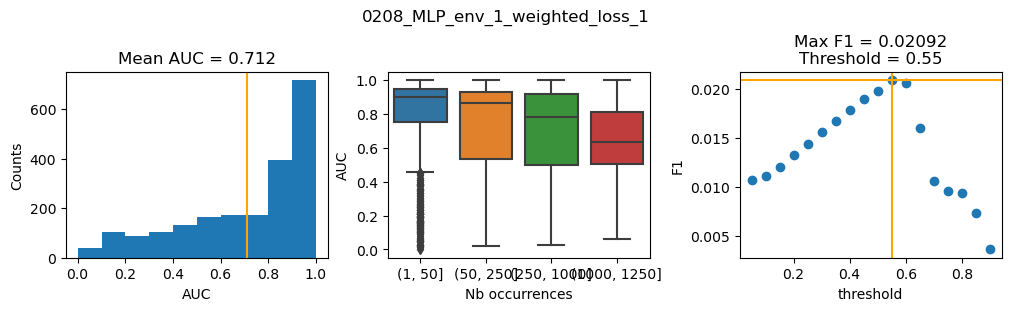

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, layout='constrained', figsize=(10,3))

mean1 = df.auc.mean()
ax1.hist(df.auc)
ax1.axvline(mean1, color='orange')
ax1.set(xlabel='AUC', ylabel='Counts', title=f"Mean AUC = {mean1:.3f}")

sns.boxplot(data=df, x="num_presences_cat", y="auc", ax=ax2)
ax2.set(xlabel='Nb occurrences', ylabel='AUC')

ax3.scatter(x=list(f1_scores.keys()), y=list(f1_scores.values()))
ax3.axhline(y=max_f1, color='orange')
ax3.axvline(x=threshold, color='orange')
ax3.set(xlabel='threshold', ylabel='F1', title=f"Max F1 = {max_f1:.5f}\nThreshold = {threshold}")

fig.suptitle(run_name)



In [57]:
mean_weights = pd.DataFrame({
    'bioclim': weights[:,:512].mean(axis=1), 'sat': weights[:,512:].mean(axis=1)
}).sort_values(['bioclim','sat'])

In [61]:
mean_weights.values.shape

(2088, 2)

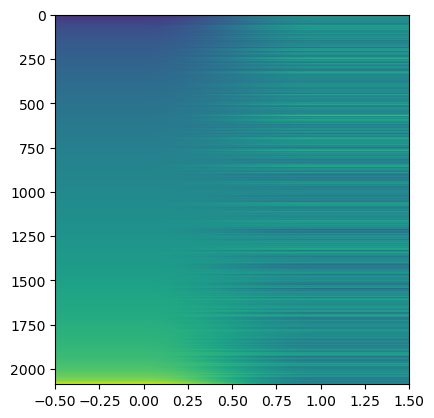

In [67]:
plt.imshow(mean_weights.values, aspect=0.001)

In [39]:
roc_auc_score(labels, y_pred)

0.7856477944925715

In [40]:
roc_auc_score(labels[:, low_occ_species_idx], y_pred[:, low_occ_species_idx])

0.8021208924074779

In [183]:
df = pd.DataFrame(train_data.species_counts, columns=['n_occ']).reset_index()
df['auc'] = [roc_auc_score(labels[:,i], y_pred[:,i]) for i in range(labels.shape[1])]
df

,index,n_occ,auc
0,1,2261,0.942233
1,5,4529,0.641626
2,10,2162,0.938100
3,11,4508,0.668044
4,24,4539,0.808725
...,...,...,...
2169,10028,204,0.913114
2170,10031,20,0.799381
2171,10035,110,0.467925
2172,10038,10,0.944332


<AxesSubplot: xlabel='n_occ', ylabel='auc'>

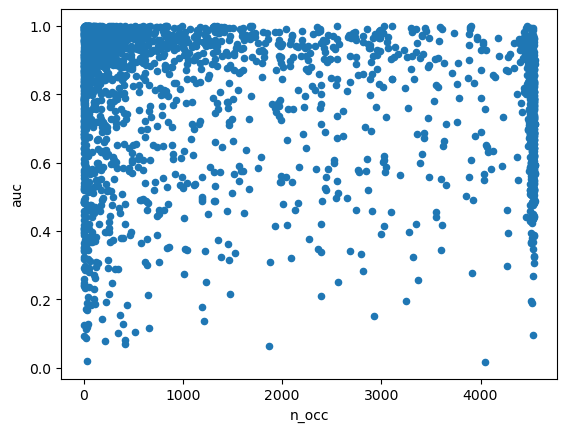

In [184]:
df.plot.scatter(x='n_occ', y='auc')

array([[<AxesSubplot: title={'center': 'auc'}>]], dtype=object)

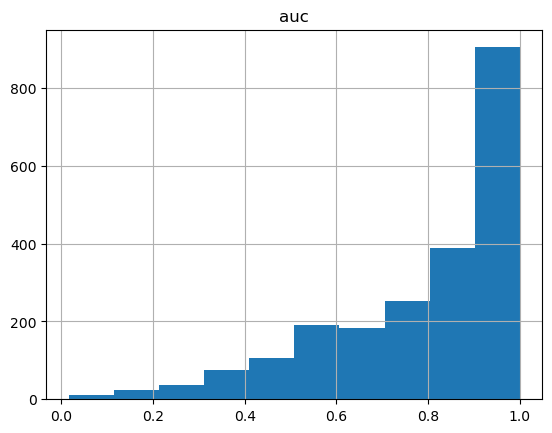

In [185]:
df.hist('auc')

In [132]:
f1_scores = {}

In [133]:
def compute_f1(labels, pred):
    tn, fp, fn, tp = confusion_matrix(labels, pred).ravel()
    f1 = tp / (tp + ((fp+fn)/2))
    return f1

In [148]:
np.arange(0.025, 1, 0.025)

array([0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225,
       0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 ,
       0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675,
       0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  ,
       0.925, 0.95 , 0.975])

In [141]:
for thresh in [0.725, 0.775, 0.825, 0.875]:#[0.1,0.2,0.3,0.4,0.5,0.6]:
    y_pred_bin = binarize(y_pred, threshold=thresh)
    f1_list = [compute_f1(labels[i,:], y_pred_bin[i,:]) for i in range(labels.shape[0])]
    f1_mean = np.mean(f1_list)
    print(thresh, '.... f1 = ', f1_mean)
    f1_scores[thresh] = f1_mean

0.725 .... f1 =  0.06117215804106441
0.775 .... f1 =  0.06264313190626879
0.825 .... f1 =  0.06173608953075929
0.875 .... f1 =  0.05883165026162659


In [142]:
dict(sorted(f1_scores.items()))

{0.1: 0.02710992021944885,
 0.2: 0.03364692441686345,
 0.3: 0.03942517650257939,
 0.4: 0.04484486907101754,
 0.5: 0.05034539790447907,
 0.6: 0.056212310325247414,
 0.7: 0.06004252688166328,
 0.725: 0.06117215804106441,
 0.75: 0.06217998207848221,
 0.775: 0.06264313190626879,
 0.8: 0.06277095937546352,
 0.825: 0.06173608953075929,
 0.85: 0.06166061019067241,
 0.875: 0.05883165026162659,
 0.9: 0.05529068820707533}

In [176]:
max_f1 = np.max(list(f1_scores.values()))
threshold = [k for k,v in f1_scores.items() if v == max_f1][0]
print('threshold', threshold)
print('max f1', max_f1)

threshold 0.8
max f1 0.06277095937546352


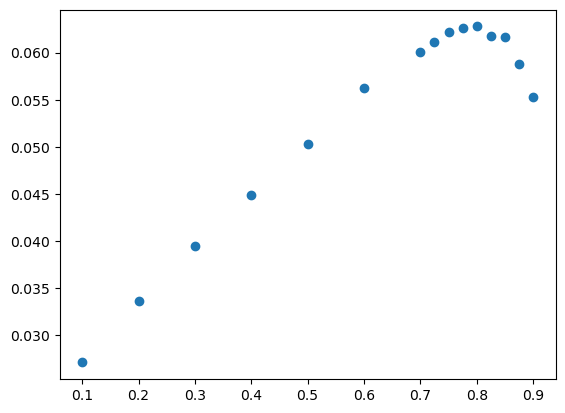

In [143]:
plt.scatter(x=f1_scores.keys(), y=f1_scores.values())

In [197]:
f1_scores

{0.1: 0.02710992021944885,
 0.2: 0.03364692441686345,
 0.3: 0.03942517650257939,
 0.4: 0.04484486907101754,
 0.5: 0.05034539790447907,
 0.6: 0.056212310325247414,
 0.7: 0.06004252688166328,
 0.8: 0.06277095937546352,
 0.9: 0.05529068820707533,
 0.75: 0.06217998207848221,
 0.85: 0.06166061019067241,
 0.725: 0.06117215804106441,
 0.775: 0.06264313190626879,
 0.825: 0.06173608953075929,
 0.875: 0.05883165026162659}

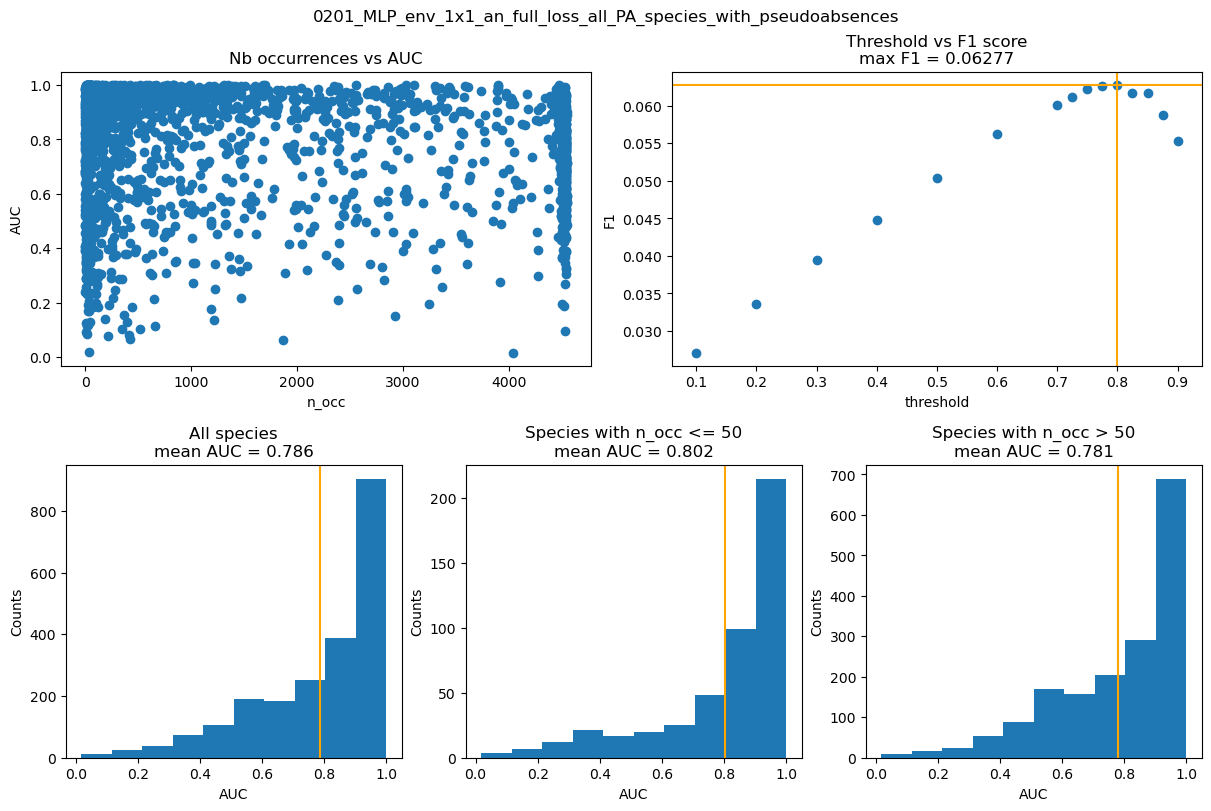

In [243]:
fig = plt.figure(layout='constrained', figsize=(12, 8))
subfigs = fig.subfigures(2, 1)

ax1, ax2 = subfigs[0].subplots(1, 2)
ax1.scatter(x=df.n_occ, y=df.auc)
ax1.set(xlabel='n_occ', ylabel='AUC', title='Nb occurrences vs AUC')

ax2.scatter(x=list(f1_scores.keys()), y=list(f1_scores.values()))
ax2.axhline(y=max_f1, color='orange')
ax2.axvline(x=threshold, color='orange')
ax2.set(xlabel='threshold', ylabel='F1', title=f"Threshold vs F1 score\nmax F1 = {max_f1:.5f}")

ax1, ax2, ax3 = subfigs[1].subplots(1, 3)
ax1.hist(df.auc)
mean1 = df.auc.mean()
ax1.axvline(mean1, color='orange')
ax1.set(xlabel='AUC', ylabel='Counts', title=f"All species\nmean AUC = {mean1:.3f}")

ax2.hist(df[df['n_occ'] <= n_max_low_occ].auc)
mean2 = df[df['n_occ'] <= n_max_low_occ].auc.mean()
ax2.axvline(mean2, color='orange')
ax2.set(xlabel='AUC', ylabel='Counts', title=f"Species with n_occ <= 50\nmean AUC = {mean2:.3f}")

ax3.hist(df[df['n_occ'] > n_max_low_occ].auc)
mean3 = df[df['n_occ'] > n_max_low_occ].auc.mean()
ax3.axvline(mean3, color='orange')
ax3.set(xlabel='AUC', ylabel='Counts', title=f"Species with n_occ > 50\nmean AUC = {mean3:.3f}")

fig.suptitle(run_name)
plt.savefig('test.png')